# Explore GP Params Clusters
Noam Siegel, Ben Gurion University

In [99]:
# imports
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pytorch_lightning import seed_everything
from sklearn import mixture
from sklearn.manifold import TSNE

from msc.dataset import DogDataset
from msc.results_collectors import GPResultsCollector

seed_everything(42)
%load_ext autoreload
%autoreload 2

Global seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load embeddings from two estimations

In [100]:
# get results of multitask (pair) GP params MLE
requested_project_name = "inference/pairs/Dog_1"
requested_params = ['covar_module.data_covar_module.base_kernel.raw_lengthscale',
                    'covar_module.data_covar_module.raw_lengthscale',
                    'covar_module.task_covar_module.covar_factor[0]',
                    'covar_module.task_covar_module.covar_factor[1]',
                    'covar_module.task_covar_module.raw_var[0]',
                    'covar_module.task_covar_module.raw_var[1]']

# using the split date to separate first estimation from second estimation
split_date = datetime.datetime(year=2022, month=2, day=10)
results_collector = GPResultsCollector(requested_project_name, requested_params, split_version_by_date=split_date)
results_df = results_collector.results_df

getting page=1/8
last page size was 363 which is l.e. 500. finished getting tasks.


## TSNE each estimation separately
(same seed)

In [101]:
seed_everything(42)
# get parameter values
X = results_df.loc[results_df['version'] == 0, results_collector.params].values

# calculate t-SNE values of parameters 1st
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

# add t-SNE results to results_df
results_df.loc[results_df['version'] == 0, 'tsne-2d-one'] = tsne_results[:, 0]
results_df.loc[results_df['version'] == 0, 'tsne-2d-two'] = tsne_results[:, 1]

# calculate t-SNE values of parameters 2nd
seed_everything(42)
# get parameter values
X = results_df.loc[results_df['version'] == 1, results_collector.params].values

# calculate t-SNE values of parameters 1st
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

# add t-SNE results to results_df
results_df.loc[results_df['version'] == 1, 'tsne-2d-one'] = tsne_results[:, 0]
results_df.loc[results_df['version'] == 1, 'tsne-2d-two'] = tsne_results[:, 1]

Global seed set to 42
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Global seed set to 42
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## Mark cluster from first estimation

In [102]:
results_df.loc[(results_df['version'] == 0) & (results_df["tsne-2d-one"] > 15), "in_cluster"] = True

In [103]:
results_df['in_cluster'] = results_df['in_cluster'].fillna(False)

In [104]:
df = pd.merge(results_df.loc[(results_df['version'] == 0)], results_df.loc[(results_df['version'] == 1)],
              on=['fname', 'name_task'], how='left', indicator='Exist')

## Plot both tSNEs with cluster

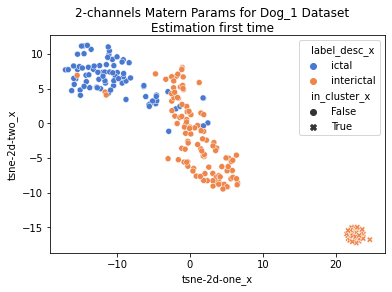

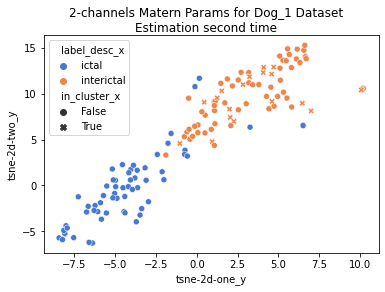

In [105]:
# plot t-sne results
sns.scatterplot(data=df,
                x='tsne-2d-one_x', y='tsne-2d-two_x',
                # hue_order=hue_order,
                hue="label_desc_x", style='in_cluster_x', palette="muted", legend=True)
plt.suptitle("2-channels Matern Params for Dog_1 Dataset\nEstimation first time")
plt.show()

# plot t-sne results
sns.scatterplot(data=df,
                x='tsne-2d-one_y', y='tsne-2d-two_y',
                # hue_order=hue_order,
                hue="label_desc_x", style='in_cluster_x', palette="muted", legend=True)
plt.suptitle("2-channels Matern Params for Dog_1 Dataset\nEstimation second time")
plt.show()

## Visually explore cluster properties

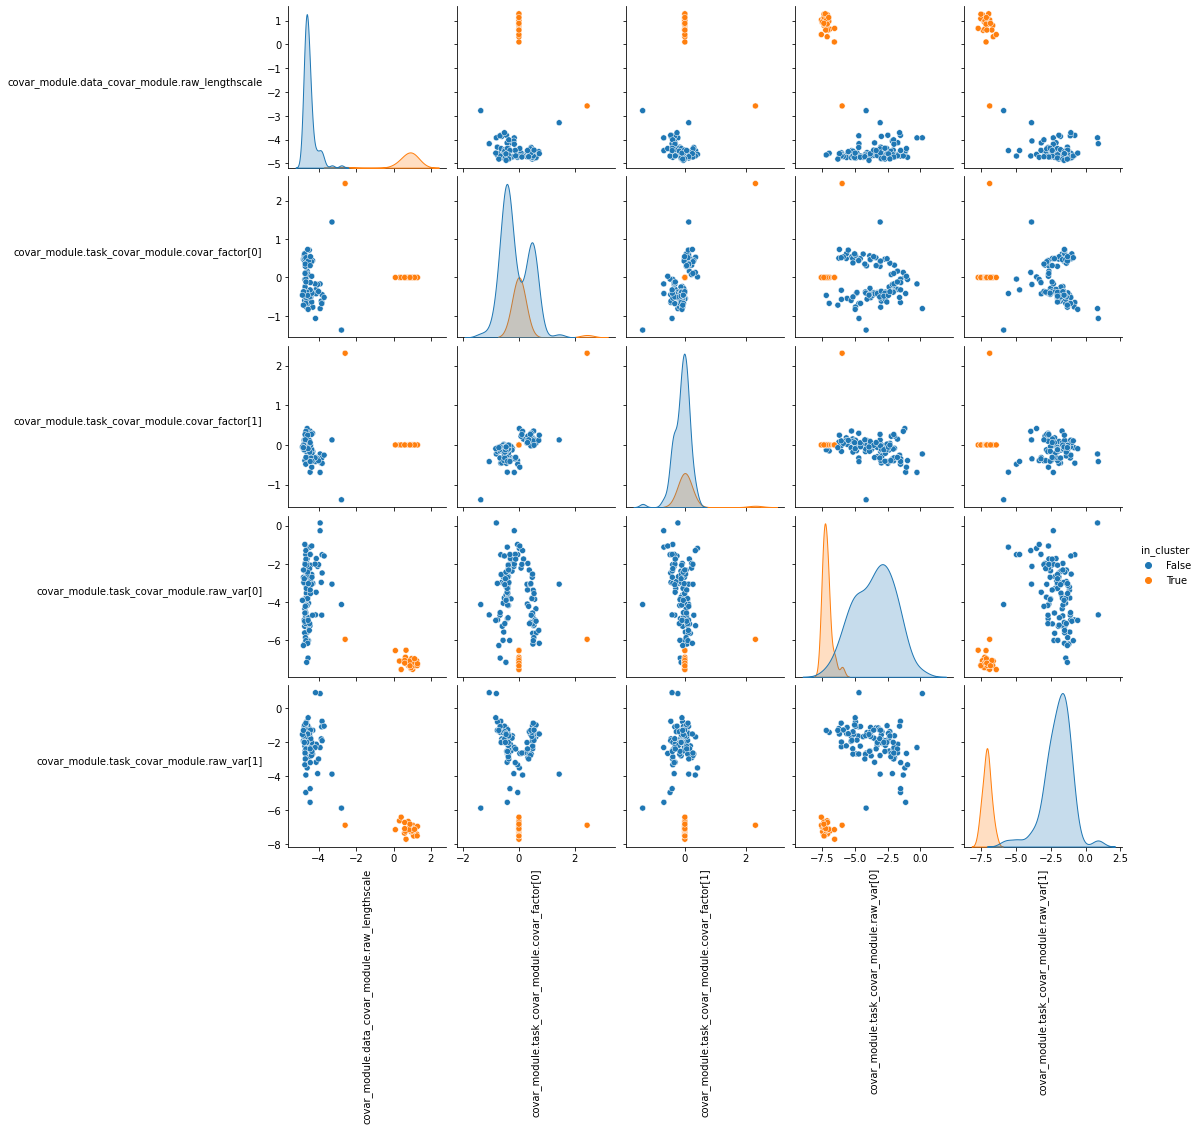

In [106]:
g = sns.pairplot(results_df.loc[(results_df['version'] == 0) & (results_df["label_desc"] == 'interictal'), requested_params + ['in_cluster']], hue='in_cluster')
for ax in g.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation=90)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation=0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

## Visually explore samples from in-cluster vs out-cluster

In [107]:
# load dataset
dataset_dir = r"C:\Users\noam\Repositories\noamsgl\msc\data\seizure-detection\Dog_1"
dataset = DogDataset(dataset_dir)
samples_df = dataset.samples_df

loading samples


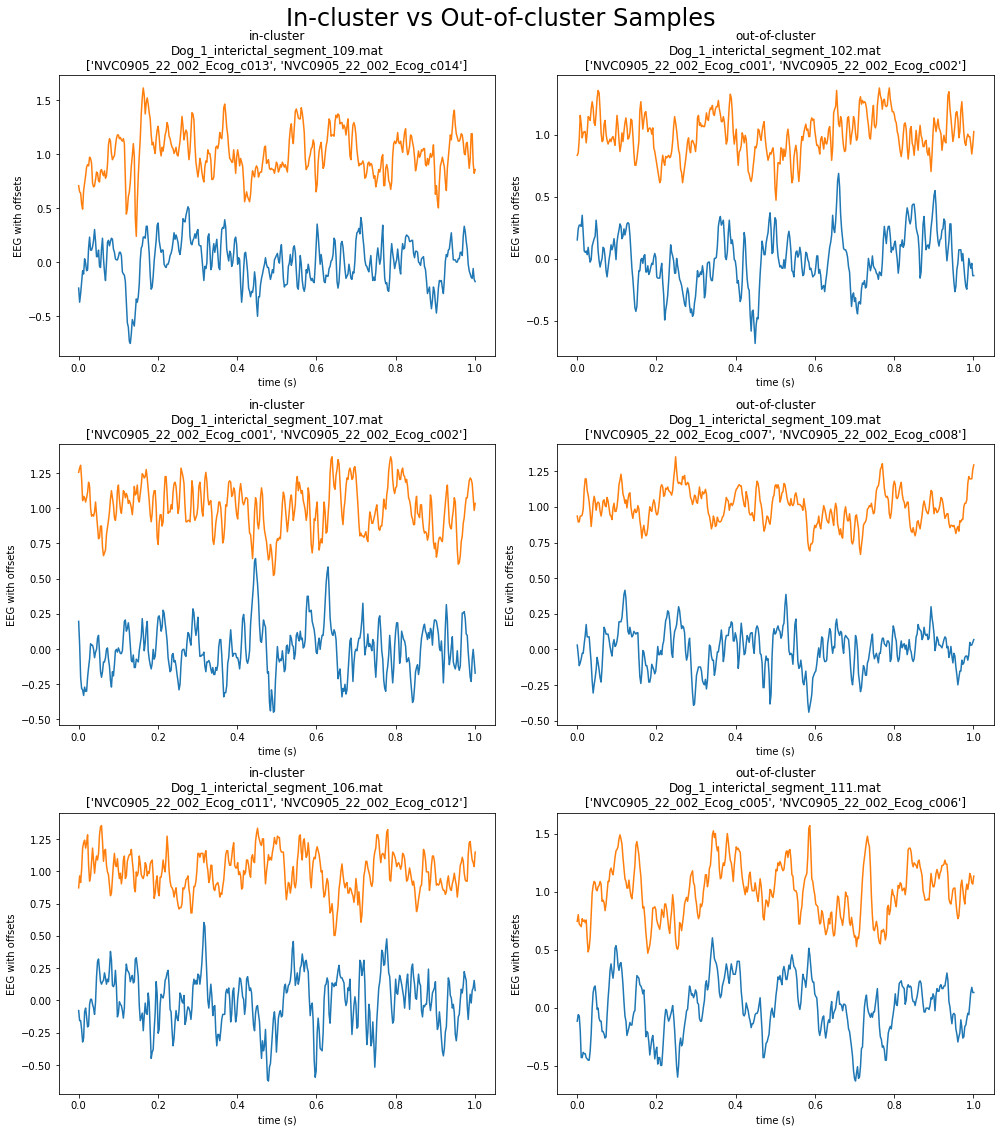

In [110]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))
for idx, (_, row) in enumerate(results_df.loc[(results_df['version'] == 0) & (results_df["label_desc"] == 'interictal') & (results_df['in_cluster'])].sample(3).iterrows()):
    sample = samples_df.loc[samples_df['fname'] == row['fname'], row['ch_names'] + ['time']]
    axs[idx, 0].set_title(f"in-cluster\n{row['fname']}\n{row['ch_names']}")
    sample.eeg.plot(ax=axs[idx, 0])

for idx, (_, row) in enumerate(results_df.loc[(results_df['version'] == 0) & (results_df["label_desc"] == 'interictal') & (~results_df['in_cluster'])].sample(3).iterrows()):
    sample = samples_df.loc[samples_df['fname'] == row['fname'], row['ch_names'] + ['time']]
    axs[idx, 1].set_title(f"out-of-cluster\n{row['fname']}\n{row['ch_names']}")
    sample.eeg.plot(ax=axs[idx, 1])

fig.suptitle('In-cluster vs Out-of-cluster Samples', fontsize=24)
plt.tight_layout()